<a href="https://colab.research.google.com/github/pa-shk/iad-intro-ds-practical-tasks/blob/main/hw07_trees_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
def entropy(probs: np.array) -> float:
  """
  Calculates entropy index based on probabilities
  """
  return -(probs @ np.log(probs).T)

In [ ]:
probs = [0.8, 0.2]
np.round(entropy(probs), 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
from collections import Counter

In [ ]:
def gini(probs: np.array) -> float:
  """
  Calculates gini index based on probabilities
  """
  return probs @ (1 - probs).T

In [ ]:
def get_probs(array: np.array) -> np.array:
  """
  Calculates probability of each value in array
  """
  counter = Counter(array)
  return np.array(list(counter.values())) / counter.total()

In [ ]:
R_m = np.array([1, 1, 2, 2, 2, 2, 2, 2, 2, 2])
R_l = np.array([1, 1])
R_r = np.array([2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
np.round(
    gini(get_probs(R_m)) - len(R_l) / len(R_m) * gini(get_probs(R_l)) - len(R_r) / len(R_m) * gini(get_probs(R_r)),
    2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
a = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
a.mean()

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def calc_information_gain(R_m: np.ndarray, R_l: np.ndarray, R_r: np.ndarray, criterion: str = 'variance') -> float:
  """
  Calculates information gain based on criterion (variance or gini)
  """
  if criterion == 'variance':
    return (
        R_m.var() - (len(R_l) / len(R_m) * R_l.var() + len(R_r) / len(R_m) * R_r.var())
        )
  return (
    gini(get_probs(R_m))- (len(R_l) / len(R_m) * gini(get_probs(R_l)) + len(R_r) / len(R_m) * gini(get_probs(R_r)))
    )

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    target_vector = np.array(target_vector)
    feature_vector = np.array(feature_vector)

    # обработка пропущенных значений - игнорируются при выборе разбиения
    not_na_mask = ~np.isnan(feature_vector)
    feature_vector = feature_vector[not_na_mask]
    target_vector = target_vector[not_na_mask]

    # константный признак или признак только из пропущенных значений
    features_sorted = np.unique(feature_vector)
    if features_sorted.shape[0] < 2:
      return np.array([0.]), np.array([0.]), 0., 0.


    criterion = 'gini' if task == "classification" else 'variance'

    if feature_type == 'real':
      thresholds = (features_sorted[1:] + features_sorted[:-1]) / 2

      # это конечно O(n ** 2) по памяти, но зато без циклов
      mask = np.tile(feature_vector, (len(thresholds), 1)).T - thresholds
      info_gain_scores = np.apply_along_axis(lambda x: calc_information_gain(target_vector,
                                                                             target_vector[x < 0],
                                                                             target_vector[x >= 0],
                                                                             criterion=criterion),
                                             axis=0,
                                             arr=mask)

    else:
      thresholds = features_sorted
      mask = np.tile(feature_vector, (len(thresholds), 1)).T - thresholds
      info_gain_scores = np.apply_along_axis(lambda x: calc_information_gain(target_vector,
                                                                             target_vector[x == 0],
                                                                             target_vector[x != 0],
                                                                             criterion=criterion),
                                             axis=0,
                                             arr=mask)

    threshold_best = thresholds[info_gain_scores.argmax()]
    best_info_gain_score = info_gain_scores.max()

    return thresholds, info_gain_scores, threshold_best, best_info_gain_score

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
thresholds, information_gain, _, _ = find_best_split(X['MedInc'], y, task='regression')

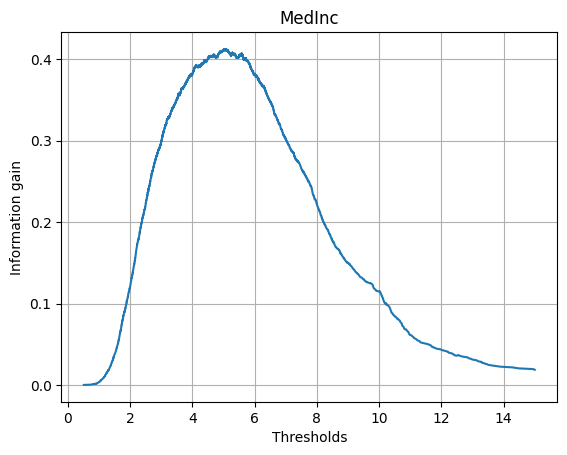

In [ ]:
fig, ax = plt.subplots()

ax.plot(thresholds, information_gain)
ax.set_xlabel('Thresholds')
ax.set_ylabel('Information gain')
ax.set_title("MedInc")

plt.grid()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
from collections import namedtuple

In [ ]:
features_scores = {}
Split = namedtuple('Split', ['information_gain', 'best_threshold'])

for column in X.columns:
  _, _, best_threshold, information_gain = find_best_split(X[column], y, task='regression')
  features_scores[column] = Split(information_gain, best_threshold)

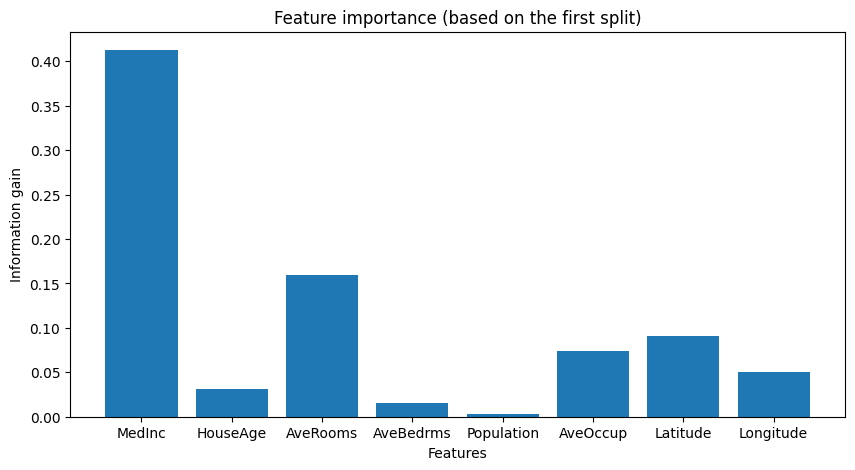

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(features_scores.keys(), [i.information_gain for i in features_scores.values()])
ax.set_xlabel('Features')
ax.set_ylabel('Information gain')
ax.set_title("Feature importance (based on the first split)")

plt.show()

Признак `Medinc` является лучшим выбором для первого разбиения

In [ ]:
features_scores

{'MedInc': Split(information_gain=0.41275138620167695, best_threshold=5.03515),
 'HouseAge': Split(information_gain=0.030900940598320936, best_threshold=51.5),
 'AveRooms': Split(information_gain=0.15920795258922515, best_threshold=6.374305146225346),
 'AveBedrms': Split(information_gain=0.015253415595943842, best_threshold=1.1033776245480702),
 'Population': Split(information_gain=0.0028306480479911578, best_threshold=1160.5),
 'AveOccup': Split(information_gain=0.07391870577793291, best_threshold=3.1125433206272035),
 'Latitude': Split(information_gain=0.09033408765371975, best_threshold=37.935),
 'Longitude': Split(information_gain=0.05021105203303011, best_threshold=-121.86500000000001)}

Наилучший предикат будет иметь вид `MedInc < 5.03515`

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
def jaccard_simularity(arr_one: np.ndarray, arr_two: np.ndarray) -> float:
  """
  Calculates jaccard simularity score between two arrays
  """
  return len(set(arr_one) & set(arr_two)) / len(set(arr_one) | set(arr_two))

In [ ]:
def find_surrogate_split(feature_vector: np.ndarray,
                         true_right: np.ndarray,
                         true_left: np.ndarray)-> Tuple[float, float]:
  """
  Finds best threshold, for simplicity all features considered real
  """
  features_sorted = np.unique(feature_vector[~np.isnan(feature_vector)])

  # feature_vector consists of nan values only
  if features_sorted.shape[0] == 0:
    return -np.inf, 0

  # feature_vector has only one unique value, all objects go to the right subtree
  if features_sorted.shape[0] == 1:
    sim_score = feature_vector.sum()
    threshold_best = features_sorted[0]
    return threshold_best, sim_score

  thresholds = (features_sorted[1:] + features_sorted[:-1]) / 2
  mask = np.tile(feature_vector, (len(thresholds), 1)).T - thresholds

  n = feature_vector.shape[0]
  simularity_scores = np.apply_along_axis(lambda x: (jaccard_simularity(np.arange(n)[x >= 0],
                                                                        np.arange(n)[true_right])

                                                    + jaccard_simularity(np.arange(n)[x < 0],
                                                                        np.arange(n)[true_left])),
                                          axis=0,
                                          arr=mask)

  threshold_best = thresholds[simularity_scores.argmax()]
  sim_score = simularity_scores.max()
  return threshold_best, sim_score

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, left_split, right_split = None, None, None, None, None


        for feature in range(sub_X.shape[1]):

            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]


            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)


            if gini_best is None or gini > gini_best:
                gini_best = gini
                if gini > 0:
                  feature_best = feature

                # расчет важности
                self._feature_importances[feature] = self._feature_importances.get(feature_best, 0) + gini * sub_X.shape[0]

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    # объекты с пропущенным значением отправляем в оба поддерева
                    left_split = np.nan_to_num(feature_vector, nan=-np.inf) < threshold
                    right_split = np.nan_to_num(feature_vector, nan=np.inf) >= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    left_split = np.nan_to_num(feature_vector, nan=threshold) == threshold
                    right_split = feature_vector != threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        # создание суррогатных признаков
        surrogates_thresholds = {}
        surrogates_scores = {}
        # для каждого признака находим порог, дающий наиболее близкое к оригинальному разбиение
        for sur_feature in range(sub_X.shape[1]):
          sur_threshold, sim_score = find_surrogate_split(feature_vector=sub_X[:, sur_feature],
                                                          true_left=left_split,
                                                          true_right=right_split)

          surrogates_thresholds[sur_feature] = sur_threshold
          surrogates_scores[sur_feature] = sim_score

        sorted_features = sorted(surrogates_thresholds.keys(), key=surrogates_scores.get, reverse=True)
        # сохраняем признаки в порядке уменьшения сходства при разбиении по лучшему порогу
        node['surrogates'] = {feature: surrogates_thresholds[feature] for feature in sorted_features}

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[left_split], sub_y[left_split], node["left_child"])
        self._fit_node(sub_X[right_split], sub_y[right_split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
          return node['class']

        threshold = node.get('threshold')
        category_split = node.get('category_split')
        value = x[node['feature_split']]

        # поиск наилучшего суррогатного предиката
        if np.isnan(value):
          for sub_feature, threshold in node['surrogates'].items():
            value = x[sub_feature]
            if not np.isnan(value):
              break

        if threshold:
          if value < threshold:
            return self._predict_node(x, node['left_child'])
          return self._predict_node(x, node['right_child'])

        if value == category_split:
          return self._predict_node(x, node['left_child'])
        return self._predict_node(x, node['right_child'])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)
        # нормализация значений важности
        importances_sum = sum(dt._feature_importances.values())
        self._feature_importances = {k: v / importances_sum for k, v in self._feature_importances.items()}

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/students.csv

--2023-06-07 18:17:49--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv.1’

students.csv.1      100%[===================>]   7.61K  --.-KB/s    in 0s      

2023-06-07 18:17:50 (80.1 MB/s) - ‘students.csv.1’ saved [7794/7794]



In [ ]:
students_df  = pd.read_csv('/content/students.csv', index_col=0)
students_df

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


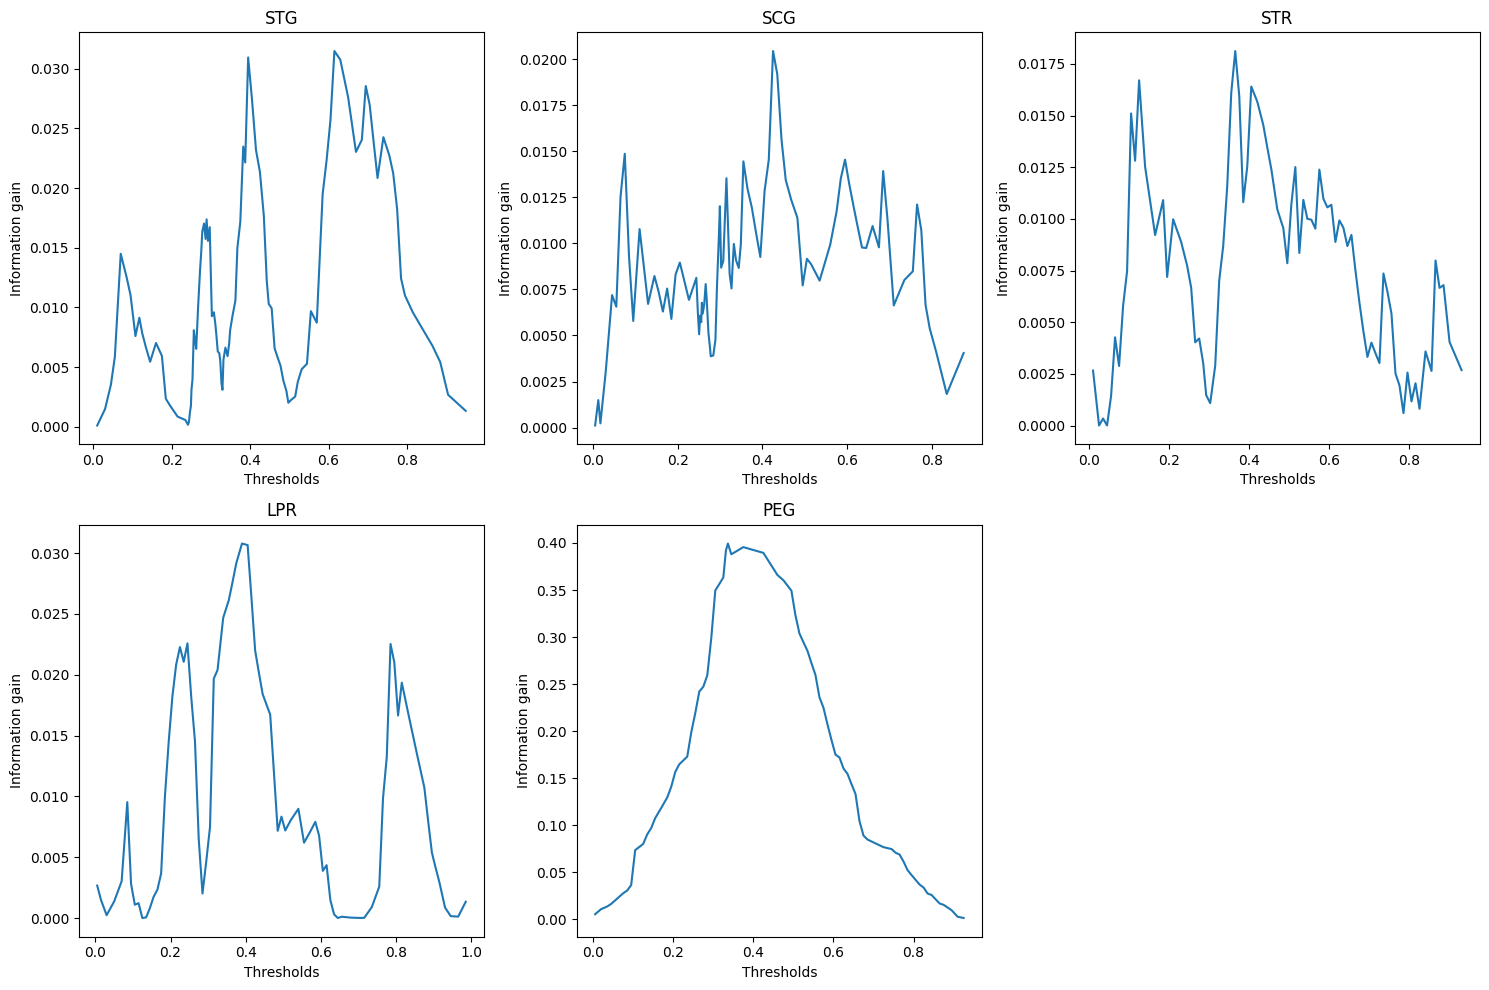

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools


gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(15, 10))


for feature, grd in zip(students_df.columns[:-1],
                        itertools.product([0, 1], [0, 1, 2])):

    ax = plt.subplot(gs[grd[0], grd[1]])
    thresholds, information_gain, _, _ = find_best_split(students_df[feature],
                                                         students_df['UNS'],
                                                         task='classification')
    ax.plot(thresholds, information_gain)
    ax.set_title(feature)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Information gain')


plt.tight_layout()
plt.show()

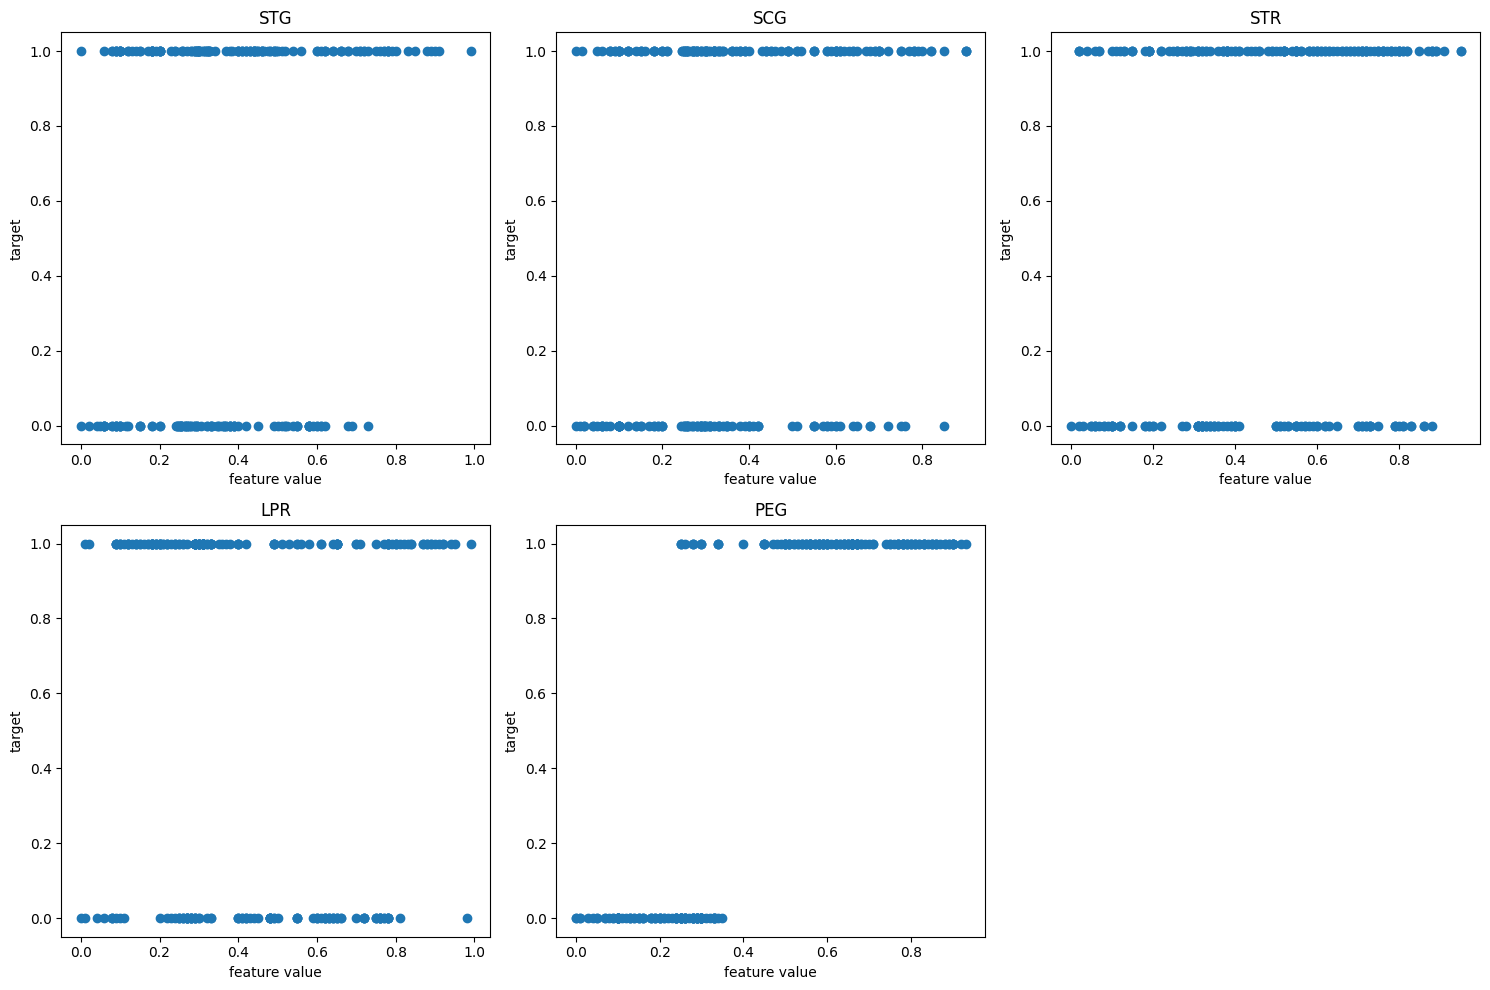

In [ ]:
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(15, 10))

for feature, grd in zip(students_df.columns[:-1],
                        itertools.product([0, 1], [0, 1, 2])):

    ax = plt.subplot(gs[grd[0], grd[1]])
    figure = plt.scatter(students_df[feature], students_df['UNS'])
    ax.set_title(feature)
    ax.set_xlabel('feature value')
    ax.set_ylabel('target')


plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?


*   Исходя из кривых значений критерия Джини, деление выборки следует производить по признаку PEG
*   Этот результат отлично согласуется с оценкой диаграмм рассеяиния. На диаграмме для признака PEG сначала все точки относятся к отрицательному классу, в районе значений от 0.2 до 0.4 "серая зона", точки могут относиться как к отрицательному, так и к положительному классу, после 0.4 точки относятся только к положительному классу. На диаграммах для других признаков точки или почти равномерно распределены между классами вне зависимости от признака или же некоторые закономерности есть, но они не столь явные
*  Кривая признака, по которому выборка хорошо разделима относительно целевой переменной, имеет одну выраженную вершину, при которой достигается достаточно большое значение критерия Джини, при значении порога меньше наилучшего кривая критерия Джини довольно плавно возрастает, при значении больше наилучшего - убывает
*  Для признаков, по которым выборка плохо разделима, кривая критерия Джини очень сильно колеблется, при этом на каждой из вершин значение критерия Джини не очень большое (на графики из-за масштаба кажется, что высота вершин для каждого признака одинаковая, но это не так)


**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
!wget https://nrvis.com/data/mldata/mushroom_agaricus-lepiota.csv

--2023-06-07 18:17:54--  https://nrvis.com/data/mldata/mushroom_agaricus-lepiota.csv
Resolving nrvis.com (nrvis.com)... 173.236.176.48
Connecting to nrvis.com (nrvis.com)|173.236.176.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373704 (365K) [text/csv]
Saving to: ‘mushroom_agaricus-lepiota.csv.1’

mushroom_agaricus-l 100%[===================>] 364.95K  --.-KB/s    in 0.1s    

2023-06-07 18:17:55 (3.25 MB/s) - ‘mushroom_agaricus-lepiota.csv.1’ saved [373704/373704]



In [ ]:
df = pd.read_csv('mushroom_agaricus-lepiota.csv')
df

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
encoders = dict(zip(X.columns, (LabelEncoder() for _ in range(X.shape[1]))))
X_train = X_train.apply(lambda x: encoders[x.name].fit_transform(x))
X_test = X_test.apply(lambda x: encoders[x.name].transform(x))

In [ ]:
dt = DecisionTree(feature_types=['categorical' for _ in range(X.shape[1])])
dt.fit(np.array(X_train), np.array(y_train))

In [ ]:
accuracy_score(y_test, dt.predict(np.array(X_test)))

1.0

Тестирования качества на пропушенных данных

In [ ]:
for col in X_train.columns:
    X_train.loc[X_train.sample(frac=0.4, random_state=42).index, col] = np.nan

for col in X_test.columns:
    X_test.loc[X_test.sample(frac=0.4, random_state=42).index, col] = np.nan

In [ ]:
dt = DecisionTree(feature_types=['categorical' for _ in range(X.shape[1])])
dt.fit(np.array(X_train), np.array(y_train))

In [ ]:
accuracy_score(y_test, dt.predict(np.array(X_test)))

0.7791728212703102

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
!wget https://raw.githubusercontent.com/pa-shk/iad-intro-ds/master/2023/homeworks/hw07-trees/diabetes.csv

--2023-06-07 18:20:30--  https://raw.githubusercontent.com/pa-shk/iad-intro-ds/master/2023/homeworks/hw07-trees/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23105 (23K) [text/plain]
Saving to: ‘diabetes.csv.1’

diabetes.csv.1      100%[===================>]  22.56K  --.-KB/s    in 0.005s  

2023-06-07 18:20:30 (4.68 MB/s) - ‘diabetes.csv.1’ saved [23105/23105]



In [ ]:
data = pd.read_csv('/content/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

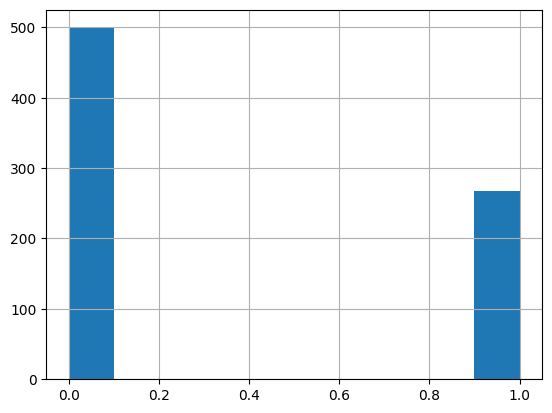

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X, y = data.drop(columns=['Outcome']), data['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train,
                                                                          test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from itertools import product
from collections import namedtuple

In [ ]:
max_depth_list = [None, 100, 50, 10, 1]
min_samples_leaf_list = [1, 5, 10, 20]

res = {}
Params = namedtuple('Params', ['max_depth', 'min_samples_leaf'])

for max_depth, min_samples_leaf in product(max_depth_list, min_samples_leaf_list):

  dt_classifier = DecisionTreeClassifier(max_depth=max_depth,
                                         min_samples_leaf=min_samples_leaf,
                                         random_state=42)

  dt_classifier.fit(X_train_train, y_train_train)
  score = f1_score(y_train_val, dt_classifier.predict(X_train_val))
  res[Params(max_depth, min_samples_leaf)] = score

In [ ]:
res

{Params(max_depth=None, min_samples_split=2): 0.6155702946186933,
 Params(max_depth=None, min_samples_split=5): 0.6533303873913685,
 Params(max_depth=None, min_samples_split=10): 0.6290958450887748,
 Params(max_depth=None, min_samples_split=20): 0.6434916357440499,
 Params(max_depth=100, min_samples_split=2): 0.6155702946186933,
 Params(max_depth=100, min_samples_split=5): 0.6533303873913685,
 Params(max_depth=100, min_samples_split=10): 0.6290958450887748,
 Params(max_depth=100, min_samples_split=20): 0.6434916357440499,
 Params(max_depth=50, min_samples_split=2): 0.6155702946186933,
 Params(max_depth=50, min_samples_split=5): 0.6533303873913685,
 Params(max_depth=50, min_samples_split=10): 0.6290958450887748,
 Params(max_depth=50, min_samples_split=20): 0.6434916357440499,
 Params(max_depth=10, min_samples_split=2): 0.6380458202376011,
 Params(max_depth=10, min_samples_split=5): 0.6371928631978037,
 Params(max_depth=10, min_samples_split=10): 0.6244846670729839,
 Params(max_depth=10,

In [ ]:
best_params = max(res, key=res.get)
best_params

Params(max_depth=None, min_samples_leaf=1)

In [ ]:
dt_classifier = DecisionTreeClassifier(max_depth=best_params.max_depth,
                                       min_samples_leaf=best_params.min_samples_leaf,
                                       random_state=42)

dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('auc_roc:', roc_auc_score(y_test, y_pred))

accuracy: 0.7012987012987013
precision: 0.5555555555555556
recall: 0.6875
auc_roc: 0.6980546357615895


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=best_params.max_depth,
                                                             min_samples_leaf=best_params.min_samples_leaf),
                            n_estimators=50,
                            random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('auc_roc:', roc_auc_score(y_test, y_pred))

accuracy: 0.7489177489177489
precision: 0.6309523809523809
recall: 0.6625
auc_roc: 0.7286009933774835


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)


max_depth_list = [None, 100, 50, 10, 1]
min_samples_split_list =  [2, 5, 10, 20]
res = {}
Params = namedtuple('Params', ['max_depth', 'min_samples_split'])


for max_depth, min_samples_split in product(max_depth_list, min_samples_split_list):
  cv_scores = []
  for train_index, test_index in kf.split(np.array(X_train)):

    rf = RandomForestClassifier(n_estimators=50,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                random_state=42)

    rf.fit(np.array(X_train)[train_index], np.array(y_train)[train_index])
    score = f1_score(np.array(y_train)[test_index], rf.predict(np.array(X_train)[test_index]))
    cv_scores.append(score)

  res[Params(max_depth, min_samples_split)] = np.array(cv_scores).mean()

In [ ]:
res

{Params(max_depth=None, min_samples_split=2): 0.6155702946186933,
 Params(max_depth=None, min_samples_split=5): 0.6533303873913685,
 Params(max_depth=None, min_samples_split=10): 0.6290958450887748,
 Params(max_depth=None, min_samples_split=20): 0.6434916357440499,
 Params(max_depth=100, min_samples_split=2): 0.6155702946186933,
 Params(max_depth=100, min_samples_split=5): 0.6533303873913685,
 Params(max_depth=100, min_samples_split=10): 0.6290958450887748,
 Params(max_depth=100, min_samples_split=20): 0.6434916357440499,
 Params(max_depth=50, min_samples_split=2): 0.6155702946186933,
 Params(max_depth=50, min_samples_split=5): 0.6533303873913685,
 Params(max_depth=50, min_samples_split=10): 0.6290958450887748,
 Params(max_depth=50, min_samples_split=20): 0.6434916357440499,
 Params(max_depth=10, min_samples_split=2): 0.6380458202376011,
 Params(max_depth=10, min_samples_split=5): 0.6371928631978037,
 Params(max_depth=10, min_samples_split=10): 0.6244846670729839,
 Params(max_depth=10,

In [ ]:
best_params = max(res, key=res.get)
best_params

Params(max_depth=None, min_samples_split=5)

In [ ]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=best_params.max_depth,
                            min_samples_split=best_params.min_samples_split,
                            random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('auc_roc:', roc_auc_score(y_test, y_pred))

accuracy: 0.7186147186147186
precision: 0.5925925925925926
recall: 0.6
auc_roc: 0.6907284768211921


Из трех моделей лучшее качество метрикам `accuracy`, `precision` и `auc_roc` показала модель `BaggingClassifier`, по метрике `recall` лучшим оказался `DecisionTreeClassifier`

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
scores = []

for n in range(1, 2000, 10):
  rf = RandomForestClassifier(n_estimators=n,
                              max_depth=best_params.max_depth,
                              min_samples_split=best_params.min_samples_split,
                              random_state=42)

  rf.fit(X_train, y_train)
  score = roc_auc_score(y_test, rf.predict(X_test))
  scores.append(score)

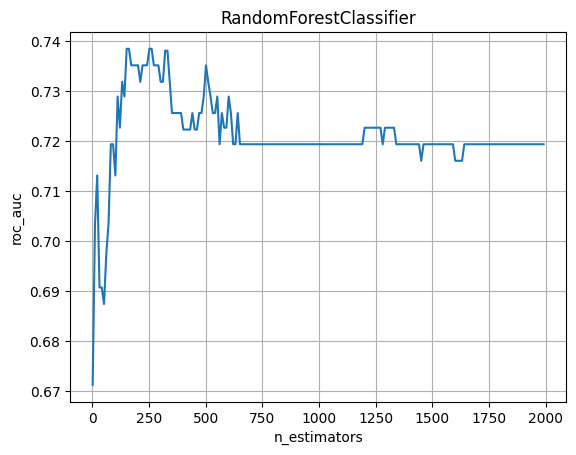

In [ ]:
fig, ax = plt.subplots()

ax.plot(list(range(1, 2000, 10)), scores)
ax.set_xlabel('n_estimators')
ax.set_ylabel('roc_auc')
ax.set_title('RandomForestClassifier')

plt.grid()
plt.show()

Кажется, случайный лес не переобучается с увеличением числа деревьев. В начале качество колеблется, но где-то после 700 деревьев выходит на плато. Еще, из этого графика видно, что, наверное, выбирать в качестве кол-ва деревьев 50 в прошлом задании было не лучшей идей, нужно было взять побольше деревьев и тогда почти гарантировано получили бы roc_auc около 0.72

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=best_params.max_depth,
                            min_samples_split=best_params.min_samples_split,
                            random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42)

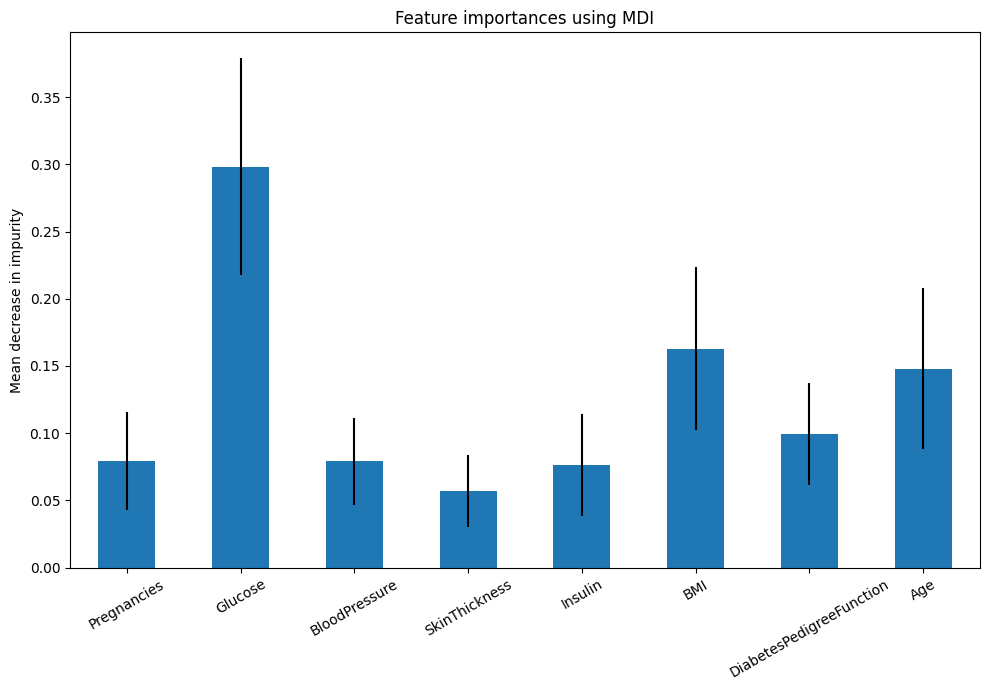

In [ ]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=30)
fig.tight_layout()

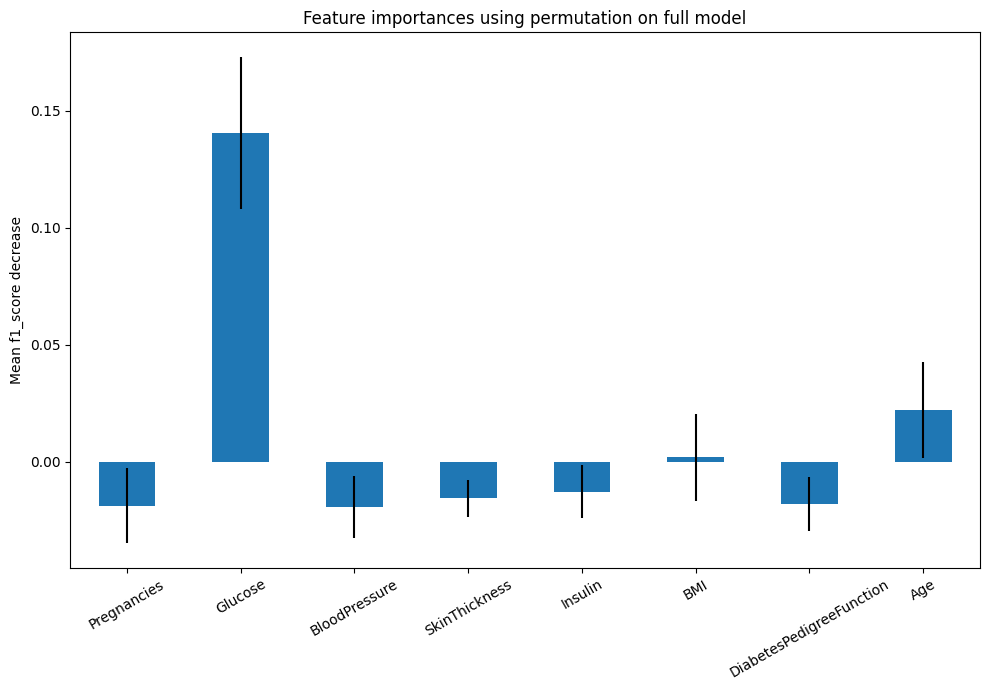

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, scoring='f1', n_repeats=10, random_state=42, n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean f1_score decrease")
plt.xticks(rotation=30)
fig.tight_layout()
plt.show()

Примечание. При выполнении задания использован код https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

При использовании двух оценок - на основе среднего прироста критерия информативности и на основе уменьшения качества при рандомном перемещивании признака, самым важным для определения диабета оказался признак `Glucose`, что кажется вполне логичным

In [ ]:
dt = DecisionTree(feature_types=['real' for _ in range(X_train.shape[1])])
dt.fit(np.array(X_train), np.array(y_train))

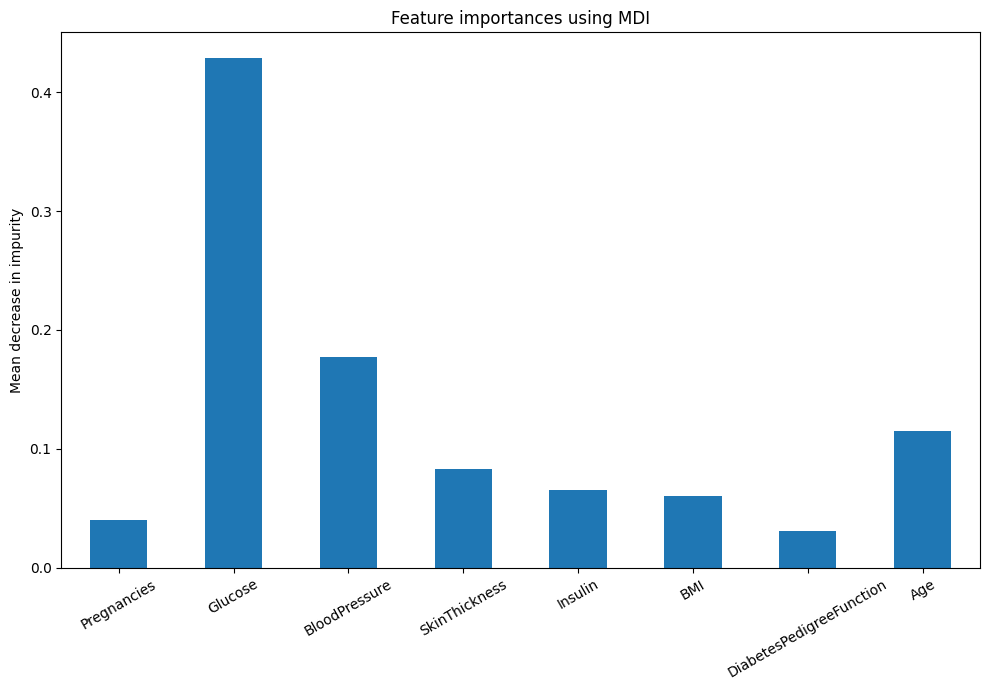

In [ ]:
tree_importances = pd.Series(np.array(list(dt._feature_importances.values())), index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 7))
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=30)
fig.tight_layout()

Оценка по одному дереву в кастомной реализации дала схожий результат